In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
### IMPORT DATA ###

df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


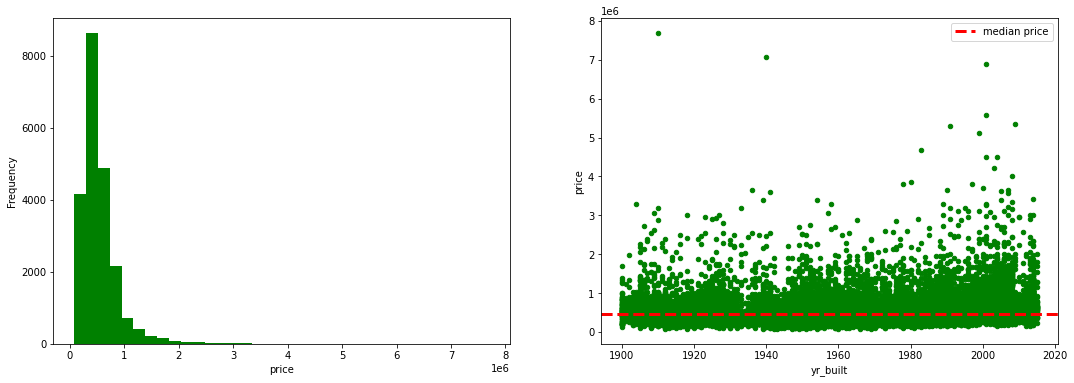

In [3]:
### PLOT DISTRIBUTIONS ###

plt.figure(figsize=(18,6))

plt.subplot((121))
df['price'].plot.hist(bins=35, ax=plt.gca(), color='green')
plt.xlabel('price')

plt.subplot((122))
df.plot.scatter(x='yr_built', y='price', ax=plt.gca(), color='green')
plt.axhline(df['price'].median(), c='red', 
            linestyle='--', linewidth=3, label='median price')
plt.legend()

plt.show()

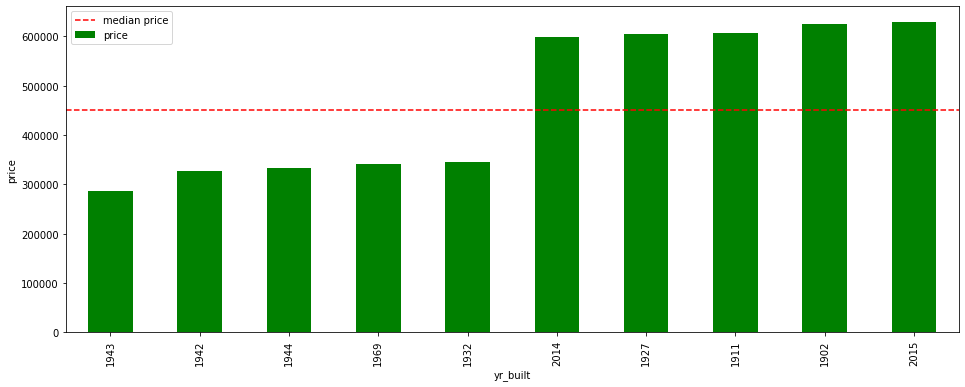

In [4]:
### HIGHEST AND LOWEST MEDIAN SELLING PRICES BY YEAR ###

df.groupby('yr_built')['price'].median().sort_values() \
    .iloc[[0,1,2,3,4,-5,-4,-3,-2,-1]].plot.bar(figsize=(16,6), color='green')
plt.axhline(df['price'].median(), c='red', 
            linestyle='--', label='median price')
plt.legend(); plt.ylabel('price')
plt.show()

In [5]:
### UNIVARIATE SIMULATION FOR A SINGLE YEAR ###

year = 2015

sampling = lambda x,y: x['price'].sample(n=int(y['count']))

y = df[df['yr_built'] == year]['price'].agg(['count','median'])

observed_diff = abs(y['median'] - df['price'].median())

sim_diffs = np.asarray([
    abs(sampling(df,y).median() - df['price'].median())    
    for i in tqdm(range(1_000))
])

p_value = np.mean(sim_diffs >= observed_diff)

100%|██████████| 1000/1000 [00:01<00:00, 628.14it/s]


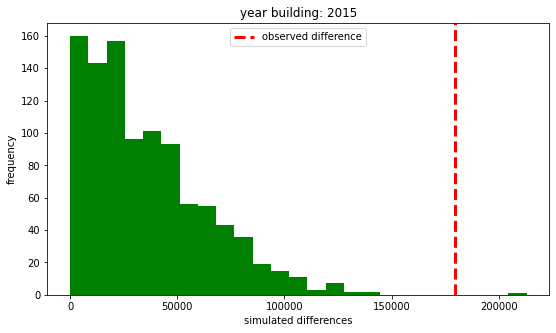

In [6]:
### PLOT UNIVARIATE SIMULATION FOR A SINGLE YEAR ###

plt.figure(figsize=(9,5))
plt.hist(sim_diffs, bins=25, color='green')
plt.axvline(observed_diff, linestyle='--', linewidth=3, c='red', 
            label='observed difference')
plt.title(f'year building: {year}')
plt.legend(); plt.xlabel('simulated differences'); plt.ylabel('frequency')
plt.show()

In [7]:
### UNIVARIATE SIMULATION FOR ALL THE YEARS ###

test_diff = {}

for y_b in tqdm(df['yr_built'].unique()):

    y = df[df['yr_built'] == y_b]['price'].agg(['count','median'])

    observed_diff = abs(y['median'] - df['price'].median())

    test_diff[y_b] = np.mean([
        abs(sampling(df,y).median() - df['price'].median()) >= observed_diff
        for i in range(500)
    ])
    
test_diff = pd.Series(test_diff).sort_index()

100%|██████████| 116/116 [01:30<00:00,  1.28it/s]


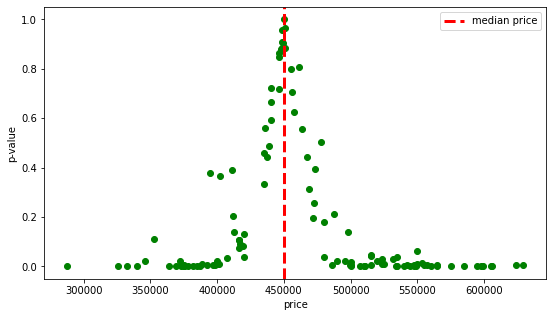

In [8]:
### PLOT UNIVARIATE SIMULATION FOR ALL THE YEAR ###

plt.figure(figsize=(9,5))
plt.scatter(df.groupby('yr_built')['price'].median(), test_diff, c='green')
plt.axvline(df['price'].median(), c='red', 
            linestyle='--', linewidth=3, label='median price')
plt.legend(); plt.xlabel('price'); plt.ylabel('p-value')
plt.show()

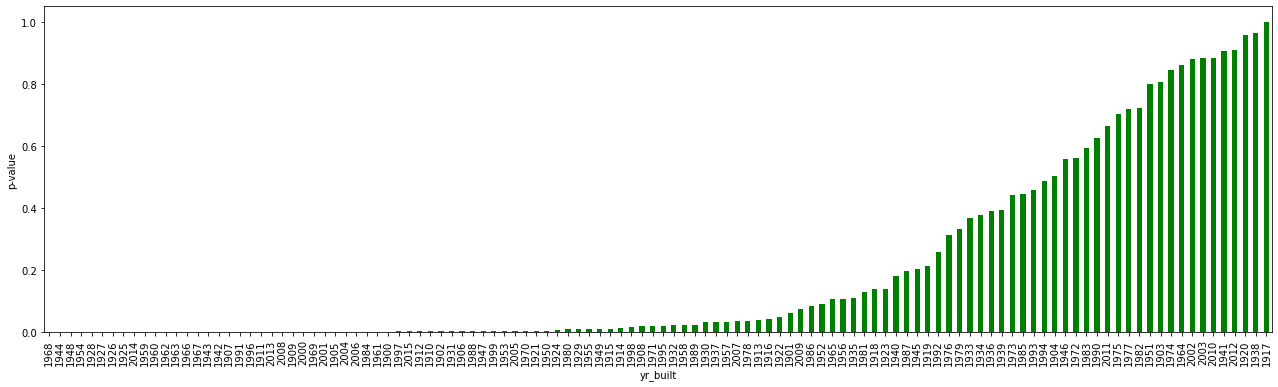

In [9]:
### PLOT UNIVARIATE SIMULATION FOR ALL THE YEAR ###

test_diff.sort_values().plot.bar(figsize=(22,6), color='green')
plt.xlabel('yr_built'); plt.ylabel('p-value')
plt.show()

In [10]:
### MULTIVARIATE SIMULATION FOR A SINGLE YEAR ###

year = 2015

cv_scoring = lambda x,y: np.mean(cross_val_score(
    RandomForestClassifier(10), 
    x, y, cv=5, scoring='roc_auc', n_jobs=-1, 
    error_score='raise'
))

observed_score = cv_scoring(
    df.drop(['yr_built','date','id'], axis=1), 
    (df['yr_built'] == year).astype(int)
)

sim_scores = np.asarray([
    cv_scoring(
        df.drop(['yr_built','date','id'], axis=1), 
        (df['yr_built'] == year).sample(frac=1).astype(int)
    )
    for i in tqdm(range(1_000))
])

p_value = np.mean(sim_scores >= observed_score)

100%|██████████| 1000/1000 [11:23<00:00,  1.46it/s]


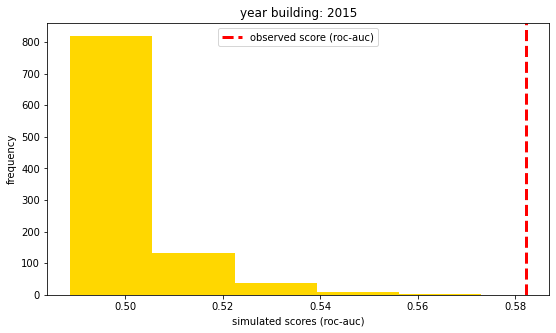

In [11]:
### PLOT MULTIVARIATE SIMULATION FOR A SINGLE YEAR ###

plt.figure(figsize=(9,5))
plt.hist(sim_scores, bins=5, color='gold')
plt.axvline(observed_score, linestyle='--', linewidth=3, c='red', 
            label='observed score (roc-auc)')
plt.title(f'year building: {year}')
plt.legend(); plt.xlabel('simulated scores (roc-auc)'); plt.ylabel('frequency')
plt.show()